In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import ImageOps, ImageEnhance
from scipy.ndimage.interpolation import map_coordinates
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.transforms import GaussianBlur
from torchvision.transforms import Lambda
import numpy as np
from skimage import exposure

# load brain_extraction data
X_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_Guys.npy')
y_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_Guys.npy')
ids_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_Guys.npy')
X_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_HH.npy')
y_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_HH.npy')
ids_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_HH.npy')
X_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_IOP.npy')
y_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_IOP.npy')
ids_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_IOP.npy')


def centring(X):
    X=np.asarray(X)
    epsilon = 1e-7
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    centered_array = (X - mean) / (std+epsilon)
    return centered_array

def to_one_hot_binary_matrix_batch(batch_matrix):
    batch_matrix = np.array(batch_matrix, dtype='int')
    one_hot = np.zeros((batch_matrix.shape[0], 2, batch_matrix.shape[1], batch_matrix.shape[2]), dtype=float)
    one_hot[:, 0] = batch_matrix == 1
    one_hot[:, 1] = batch_matrix == 0
    return one_hot


X_Guys_centered=centring(X_Guys)
X_HH_centered=centring(X_HH)
X_IOP_centered=centring(X_IOP)

# producing required train / val / test split
print("initial shapes")
print(X_Guys.shape)
print(y_Guys.shape)
print(ids_Guys.shape)
print(X_HH.shape)
print(y_HH.shape)
print(ids_HH.shape)
print(X_IOP.shape)
print(y_IOP.shape)
print(ids_IOP.shape)

combined_Guys_HH_X = np.concatenate([X_Guys_centered, X_HH_centered], axis=0)
combined_Guys_HH_y = np.concatenate([y_Guys, y_HH], axis=0)

X_train = torch.Tensor(combined_Guys_HH_X[0:int(len(combined_Guys_HH_X)*0.85)])
y_train = torch.Tensor(combined_Guys_HH_y[0:int(len(combined_Guys_HH_y)*0.85)])

# val data 15%
X_val = torch.Tensor(combined_Guys_HH_X[int(len(combined_Guys_HH_X)*0.85):int(len(combined_Guys_HH_X))])
y_val = torch.Tensor(combined_Guys_HH_y[int(len(combined_Guys_HH_y)*0.85):int(len(combined_Guys_HH_y))])
#test data from IOP data
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])

print("Check after split")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

# slice data into 2D
def reslice(x, split_size):
  temp = torch.split(x,split_size,dim=1)
  output=[]
  for i in range(len(temp)):
    output.append(temp[i])
  output=torch.cat(output, dim=0)
  return output

X_train=reslice(X_train,5)[:,0,:,:]
y_train=reslice(y_train,5)[:,0,:,:]
X_val=reslice(X_val,5)[:,0,:,:]
y_val=reslice(y_val,5)[:,0,:,:]
X_test=reslice(X_test,5)[:,0,:,:]
y_test=reslice(y_test,5)[:,0,:,:]


#X_train=X_train[:,10,:,:]
#X_val=X_val[:,20,:,:]
#X_test=X_test[:,30,:,:]
#y_train=y_train[:,10,:,:]
#y_val=y_val[:,20,:,:]
#y_test=y_test[:,30,:,:]

#introduce channel
#X_train=torch.reshape(X_train,(len(X_train),1,128,128))
#X_val=torch.reshape(X_val,(len(X_val),1,128,128))
#X_test=torch.reshape(X_test,(len(X_test),1,128,128))
y_train = torch.reshape(y_train,(len(y_train),128,128))
y_val= torch.reshape(y_val,(len(y_val),128,128))
y_test = torch.reshape(y_test,(len(y_test),128,128))
y_train = to_one_hot_binary_matrix_batch(y_train)
y_val= to_one_hot_binary_matrix_batch(y_val)
y_test = to_one_hot_binary_matrix_batch(y_test)


print("Check shapes after slicing into 2D")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test)

class numpy_dataset(Dataset): 
    def __init__(self, data, target): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

print("amount of training data")
print(len(X_train))
print(len(y_train))

print("amount of val data")
print(len(X_val))
print(len(y_val))
print("amount of test data")
print(len(X_test))
print(len(y_test))
print(X_train.shape)
print(y_train.shape)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
initial shapes
(317, 40, 128, 128)
(317, 40, 128, 128)
(317,)
(176, 40, 128, 128)
(176, 40, 128, 128)
(176,)
(71, 40, 128, 128)
(71, 40, 128, 128)
(71,)
Check after split
torch.Size([419, 40, 128, 128])
torch.Size([419, 40, 128, 128])
torch.Size([74, 40, 128, 128])
torch.Size([74, 40, 128, 128])
torch.Size([71, 40, 128, 128])
torch.Size([71, 40, 128, 128])
Check shapes after slicing into 2D
torch.Size([3352, 128, 128])
(3352, 2, 128, 128)
torch.Size([592, 128, 128])
(592, 2, 128, 128)
torch.Size([568, 128, 128])
(568, 2, 128, 128)
amount of training data
3352
3352
amount of val data
592
592
amount of test data
568
568
(3352, 128, 128)
(3352, 2, 128, 128)


Models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SegNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes


        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x, pool1_indices = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x, pool2_indices = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x, pool3_indices = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x, pool4_indices = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x, pool5_indices = self.pool(x)
        x = self.unpool(x, pool5_indices)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.unpool(x, pool4_indices)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.unpool(x, pool3_indices)
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.unpool(x, pool2_indices)
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)


class FCN_flexible(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=5):
        super(FCN_flexible, self).__init__()
        encoder_layers = []
        in_channels = input_shape[0]
        for i in range(num_layers):
            out_channels = 64 * (2 ** i)
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*encoder_layers)
        self.middle = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        )
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            out_channels = 64 * (2 ** i)
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob)
            ])
            in_channels = out_channels

        decoder_layers.extend([
            nn.Conv2d(out_channels, num_classes, kernel_size=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.pool(x))

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.init_conv = conv_block(in_channels, 64)
        self.encoders = nn.ModuleList([
            Encoder(64, 128),
            Encoder(128, 256),
            Encoder(256, 512),
            Encoder(512, 1024)
        ])
        self.decoders = nn.ModuleList([
            Decoder(1024, 512),
            Decoder(512, 256),
            Decoder(256, 128),
            Decoder(128, 64)
        ])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.init_conv(x)
        skips = [x1]
        for encoder in self.encoders:
            skips.append(encoder(skips[-1]))

        x = skips.pop()
        for decoder in self.decoders:
            x = decoder(x, skips.pop())

        return self.final_conv(x)


def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

def train_loop(model, loader, loss_func,optimizer):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image = image.to(device).float()
        mask = mask.to(device).float()
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return train_dices, train_losses

def eval_loop(model, loader, loss_func, scheduler,training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device).float()
            mask = mask.to(device).float()
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            
            val_loss += loss
            val_dice += dice
        
        val_mean_dice = val_dice / len(loader)
        val_mean_loss = val_loss / step
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

def predict(net, test_dataloader):
    test_dice=0

    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
    return data.data.cpu().numpy(),target.data.cpu().numpy(),pred.data.cpu().numpy()

def train_model_early_stopping(train_loader, val_loader, loss_func,optimizer, scheduler, num_epochs, patience=5):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    best_val_dice = 0
    consecutive_no_improvement = 0
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func,scheduler)
        
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))

        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            consecutive_no_improvement = 0
            print('Best validation dice coefficient improved to {:.3f}'.format(best_val_dice))
        else:
            consecutive_no_improvement += 1
            print('No improvement in validation dice coefficient for {} consecutive epochs'.format(consecutive_no_improvement))
            if consecutive_no_improvement >= patience:
                print('Early stopping triggered after {} epochs'.format(epoch+1))
                break

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history,epoch+1

Data augmentation

In [ ]:


def random_rotate(image, label, degree_range=(-10, 10)):
    angle = random.uniform(degree_range[0], degree_range[1])
    image = F.rotate(image, angle)
    label = F.rotate(label, angle)
    return image, label

def random_flip(image, label, p_horizontal=0.5, p_vertical=0.5):
    if random.random() < p_horizontal:
        image = F.hflip(image)
        label = F.hflip(label)
    
    if random.random() < p_vertical:
        image = F.vflip(image)
        label = F.vflip(label)
        
    return image, label

def random_scale(image, label, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    image = F.resize(image, (int(image.height * scale), int(image.width * scale)))
    label = F.resize(label, (int(label.height * scale), int(label.width * scale)))
    return image, label

def random_translate(image, label, max_shift=(10, 10)):
    shift_x = random.randint(-max_shift[0], max_shift[0])
    shift_y = random.randint(-max_shift[1], max_shift[1])
    image = F.affine(image, 0, (shift_x, shift_y), 1, 0)
    label = F.affine(label, 0, (shift_x, shift_y), 1, 0)
    return image, label


def elastic_deformation(image, label, alpha, sigma):

    image_np = np.array(image)
    label_np = np.array(label)
    
 
    if image_np.ndim == 2:
    
        image_np = np.expand_dims(image_np, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[-1] != 3:
 
        image_np = np.repeat(image_np[..., np.newaxis], 3, axis=-1)
    
  
    shape = image_np.shape[:-1]
    dx = gaussian_filter(np.random.randn(*shape), sigma) * alpha
    dy = gaussian_filter(np.random.randn(*shape), sigma) * alpha
    

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    indices = tuple(indices[..., c] for c in range(image_np.shape[-1]))
    

    image_np = map_coordinates(image_np, indices, order=1, mode='reflect')
    label_np = map_coordinates(label_np, indices[:2], order=1, mode='reflect')
    

    image = Image.fromarray(image_np.astype(np.uint8))
    label = Image.fromarray(label_np.astype(np.uint8))
    
    return image, label

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(*image.size()) * std + mean
    noisy_image = torch.clamp(image + noise, 0, 1)
    return noisy_image

def random_gaussian_blur(image):
    kernel_size = random.choice([3, 5, 7])
    sigma = random.uniform(0.1, 2.0)
    blur = GaussianBlur(kernel_size, sigma)
    return blur(image)

def random_brightness_contrast(image, brightness_factor=None, contrast_factor=None):
    if brightness_factor is None:
        brightness_factor = random.uniform(0.5, 1.5)
    if contrast_factor is None:
        contrast_factor = random.uniform(0.5, 1.5)
    
    image = TF.adjust_brightness(image, brightness_factor)
    image = TF.adjust_contrast(image, contrast_factor)
    return image

def hist_equalize(img):
    img_np = np.array(img)
    img_np = exposure.equalize_hist(img_np) * 255
    return Image.fromarray(img_np.astype(np.uint8))

<ipython-input-7-0f155e47193d>:8: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [ ]:
import random
from torchvision.transforms import transforms
from PIL import Image

class CustomTransform(object):
    def __init__(self, p_horizontal=0.5, p_vertical=0.5, scale_range=(0.8, 1.2), max_shift=(10, 10)):
        self.p_horizontal = p_horizontal
        self.p_vertical = p_vertical
        self.scale_range = scale_range
        self.max_shift = max_shift

    def __call__(self, image, label):
        # randomly apply augmentations

        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if isinstance(label, torch.Tensor):
            label = transforms.ToPILImage()(label)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)
        return image, label

class numpy_dataset(Dataset): 
    def __init__(self, data, target): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        self.transform = CustomTransform()
        # apply transform
        #y, y = self.transform(x, y)
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)


torch.Size([16, 1, 128, 128])


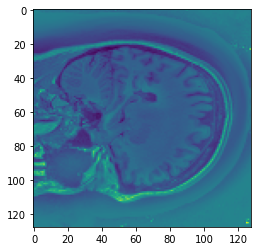

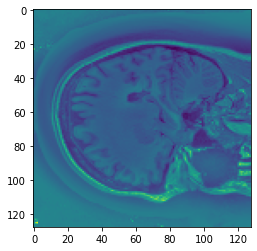

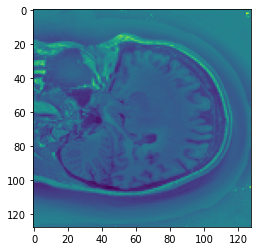

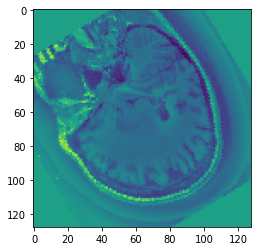

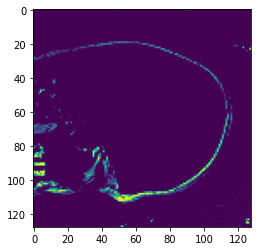

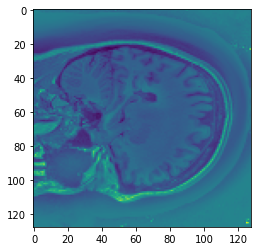

In [ ]:
img, lab = next(iter(train_dataloader))
print(img.shape)
plt.imshow(img[0][0])
plt.show()
img_flip_h = transforms.RandomHorizontalFlip(p=1)(img[0][0])
plt.imshow(img_flip_h)
plt.show()
img_flip_v = transforms.RandomVerticalFlip(p=1)(img[0][0])
plt.imshow(img_flip_v)
plt.show()
img_rot = transforms.RandomRotation(degrees=80)(img[0])[0]
plt.imshow(img_rot)
plt.show()
img_contrast=image = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)(img[0])[0]
plt.imshow(img_contrast)
plt.show()
img_blur= transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(img[0])[0]
plt.imshow(img_blur)
plt.show()

# training setup

In [ ]:
# train unet 
class numpy_dataset(Dataset): 
    def __init__(self, data, target): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        self.transform = CustomTransform()
        # apply transform
        x, y = self.transform(x, y)
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=2, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
start_time = time.time()
train_loss_history, train_dice_history, val_loss_history, val_dice_history,e = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
end_time = time.time()

Epoch: 1/100 |  Train Loss: 0.247, Val Loss: 0.144, Train DICE: 0.950, Val DICE: 0.964
Best validation dice coefficient improved to 0.964
Epoch: 2/100 |  Train Loss: 0.102, Val Loss: 0.105, Train DICE: 0.974, Val DICE: 0.973
Best validation dice coefficient improved to 0.973
Epoch: 3/100 |  Train Loss: 0.082, Val Loss: 0.088, Train DICE: 0.979, Val DICE: 0.978
Best validation dice coefficient improved to 0.978
Epoch: 4/100 |  Train Loss: 0.073, Val Loss: 0.077, Train DICE: 0.981, Val DICE: 0.980
Best validation dice coefficient improved to 0.980
Epoch: 5/100 |  Train Loss: 0.067, Val Loss: 0.071, Train DICE: 0.982, Val DICE: 0.982
Best validation dice coefficient improved to 0.982
Epoch: 6/100 |  Train Loss: 0.062, Val Loss: 0.078, Train DICE: 0.984, Val DICE: 0.980
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 7/100 |  Train Loss: 0.059, Val Loss: 0.081, Train DICE: 0.984, Val DICE: 0.980
No improvement in validation dice coefficient for 2 consecutive e

In [ ]:
prediction_dice(model,test_dataloader)

0.956254865164409

In [ ]:
# save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/dhl_exam/models_data_aug/base_8_slices.pth')